# Automated doubly robust estimation with ChiRho

## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
from typing import Callable, Optional, Tuple

import functools
import torch
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import pyro
import pyro.distributions as dist

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers.condition import condition
from chirho.observational.handlers.predictive import PredictiveModel
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator, one_step_corrected_estimator 

pyro.settings.set(module_local_params=True)

sns.set_style("white")

pyro.set_rng_seed(321) # for reproducibility

## Overview: automated robust estimation pipeline

In this tutorial, we will use ChiRho to estimate the average treatment effect (ATE) from observational data. We will use a simple example to illustrate the basic concepts of doubly robust estimation and how ChiRho can be used to automate the process for more general summaries of interest. 

There are five main steps to our doubly robust estimation procedure but only the last step is different from a standard probabilistic programming workflow:
1. Write model of interest
    - Define probabilistic model of interest using Pyro
2. Feed in data
    - Observed data used to train the model
3. Run inference
    - Use Pyro's rich inference library to fit the model to the data
4. Define target functional
    - This is the model summary of interest (e.g. average treatment effect)
5. Compute robust estimate
    - Use ChiRho to compute the doubly robust estimate of the target functional
    - Importantly, this step is automated and does not require refitting the model for each new functional


Our proposed automated robust inference pipeline is summarized in the figure below.

![fig1](figures/robust_pipeline.png)

## Causal Probabilistic Program

### Model Description
In this example, we will focus on a cannonical model `CausalGLM` consisting of three types of variables: binary treatment (`A`), confounders (`X`), and response (`Y`). For simplicitly, we assume that the response is generated from a generalized linear model with link function $g$. The model is described by the following generative process:

$$
\begin{align*}
X &\sim \text{Normal}(0, I_p) \\
A &\sim \text{Bernoulli}(\pi(X)) \\
\mu &= \beta_0 + \beta_1^T X + \tau A \\
Y &\sim \text{ExponentialFamily}(\text{mean} = g^{-1}(\mu))
\end{align*}
$$

where $p$ denotes the number of confounders, $\pi(X)$ is the probability of treatment conditional on confounders $X$, $\beta_0$ is the intercept, $\beta_1$ is the confounder effect, and $\tau$ is the treatment effect.

In [2]:
gaussian_link = lambda mu: dist.Normal(mu, 0.3)
# bernoulli_link = lambda mu: dist.Bernoulli(logits=mu)
relaxed_bernoulli_link = lambda mu: dist.RelaxedBernoulli(temperature=torch.tensor(0.01), logits=mu)

default_link = gaussian_link

vi_family = pyro.infer.autoguide.AutoDelta
vi_steps = 5000
N_datasets = 60

class CausalGLM(pyro.nn.PyroModule):
    def __init__(
        self,
        p: int,
        link_fn: Callable[..., dist.Distribution] = default_link,
        prior_scale: Optional[float] = None,
    ):
        super().__init__()
        self.p = p
        self.link_fn = link_fn
        if prior_scale is None:
            self.prior_scale = 1 / math.sqrt(self.p)
        else:
            self.prior_scale = prior_scale

    @pyro.nn.PyroSample
    def outcome_weights(self):
        return dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1)

    @pyro.nn.PyroSample
    def intercept(self):
        return dist.Normal(0.0, 1.0)

    @pyro.nn.PyroSample
    def propensity_weights(self):
        return dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1)

    @pyro.nn.PyroSample
    def treatment_weight(self):
        return dist.Normal(0.0, 1.0)

    @property
    def covariate_loc(self):
        return torch.zeros(self.p)
    
    @property
    def covariate_scale(self):
        return torch.ones(self.p)

    def forward(self):
        X = pyro.sample("X", dist.Normal(self.covariate_loc, self.covariate_scale).to_event(1))
        A = pyro.sample(
            "A",
            dist.Bernoulli(
                logits=torch.einsum("...i,...i->...", X, self.propensity_weights)
            ),
        )

        return pyro.sample(
            "Y",
            self.link_fn(
                torch.einsum("...i,...i->...", X, self.outcome_weights) + A * self.treatment_weight + self.intercept
            ),
        )

Next, we will condition on both treatment and confounders to estimate the causal effect of treatment on the outcome. We will use the following causal probabilistic program to do so:

In [3]:
class ConditionedModel(CausalGLM):

    def forward(self, *, X: torch.Tensor, A: torch.Tensor, Y: torch.Tensor):
        with condition(data={"X": X, "A": A, "Y": Y}):
            self.intercept, self.outcome_weights, self.propensity_weights, self.treatment_weight
            with pyro.plate("__train__", size=X.shape[0], dim=-1):
                return super().forward()

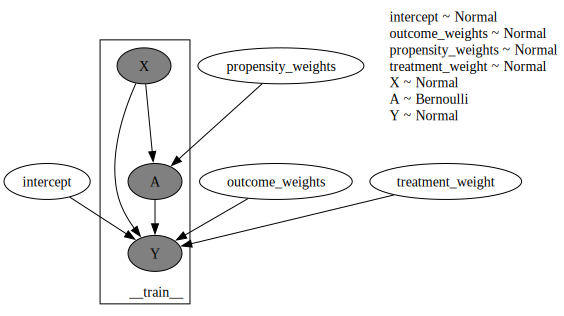

In [4]:
# Visualize the model
pyro.render_model(
    lambda: ConditionedModel(p=1)(X=torch.zeros(1, 1), A=torch.zeros(1), Y=torch.zeros(1)),
    render_params=True, 
    render_distributions=True
)

### Generating data

For evaluation, we generate `N_datasets` datasets, each with `N` samples. We compare vanilla estimates of the target functional with the double robust estimates of the target functional across the `N_sims` datasets. We use a similar data generating process as in Kennedy (2022).

In [5]:
class GroundTruthModel(CausalGLM):
    def __init__(
        self,
        p: int,
        alpha: int,
        beta: int,
        link_fn: Callable[..., dist.Distribution] = default_link,
    ):
        super().__init__(p, link_fn)
        self.alpha = alpha  # sparsity of propensity weights
        self.beta = beta  # sparsity of outcome weights

    @property
    def outcome_weights(self):
        weights = torch.zeros(self.p)
        weights[:self.beta] = 0.5  # Weaker outcome effects
        return weights
    
    @property
    def propensity_weights(self):
        # Strong but very simple propensity model
        weights = torch.zeros(self.p)
        weights[:self.alpha] = 1.0  # Strong enough for clear assignment
        return weights

    @property
    def treatment_weight(self):
        return torch.tensor(0.)

    @property
    def intercept(self):
        return torch.tensor(0.0)


In [6]:
# N_datasets = 100
simulated_datasets = []

# Data configuration
p = 30
alpha = 2
beta = 5
N_train = 500
N_test = 500

true_model = GroundTruthModel(p, alpha, beta)

for _ in tqdm(range(N_datasets)):
    # Generate data
    D_train = pyro.infer.Predictive(
        true_model, num_samples=N_train, return_sites=["X", "A", "Y"], parallel=True
    )()
    D_test = pyro.infer.Predictive(
        true_model, num_samples=N_test, return_sites=["X", "A", "Y"], parallel=True
    )()
    simulated_datasets.append((D_train, D_test))

  0%|          | 0/60 [00:00<?, ?it/s]

### Fit parameters via maximum likelihood

In [7]:
trained_guides = []
for i in tqdm(range(N_datasets)):
    # Generate data
    D_train = simulated_datasets[i][0]

    # Fit model using maximum likelihood
    conditioned_model = ConditionedModel(p=D_train["X"].shape[1])
    
    guide_train = vi_family(conditioned_model)
    elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)

    # initialize parameters
    elbo(X=D_train["X"], A=D_train["A"], Y=D_train["Y"])
    adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

    # Do gradient steps
    for _ in range(vi_steps):
        adam.zero_grad()
        loss = elbo(X=D_train["X"], A=D_train["A"], Y=D_train["Y"])
        loss.backward()
        adam.step()

    trained_guides.append(guide_train)

  0%|          | 0/60 [00:00<?, ?it/s]

## Causal Query: Average treatment effect (ATE)

The average treatment effect summarizes, on average, how much the treatment changes the response, $ATE = \mathbb{E}[Y|do(A=1)] - \mathbb{E}[Y|do(A=0)]$. The `do` notation indicates that the expectations are taken according to *intervened* versions of the model, with $A$ set to a particular value. Note from our [tutorial](tutorial_i.ipynb) that this is different from conditioning on $A$ in the original `causal_model`, which assumes $X$ and $T$ are dependent.


To implement this query in ChiRho, we define the `ATEFunctional` class which take in a `model` and `guide` and returns the average treatment effect by simulating from the posterior predictive distribution of the model and guide.

### Defining the target functional

In [8]:
class ATEFunctional(torch.nn.Module):
    def __init__(self, model: Callable, *, num_monte_carlo: int = 100):
        super().__init__()
        self.model = model
        self.num_monte_carlo = num_monte_carlo
    
    def forward(self, *args, **kwargs):
        with MultiWorldCounterfactual():
            with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
                with do(actions=dict(A=(torch.tensor(0.0), torch.tensor(1.0)))):
                    Ys = self.model(*args, **kwargs)
                Y0 = gather(Ys, IndexSet(A={1}), event_dim=0)
                Y1 = gather(Ys, IndexSet(A={2}), event_dim=0)
        ate = (Y1 - Y0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        return pyro.deterministic("ATE", ate)

### Closed form doubly robust correction

For the average treatment effect functional, there exists a closed-form analytical formula for the doubly robust correction. This formula is derived in Kennedy (2022) and is implemented below:

In [9]:
# Closed form expression
def closed_form_doubly_robust_ate_correction(X_test, theta) -> Tuple[torch.Tensor, torch.Tensor]:
    X = X_test["X"]
    A = X_test["A"]
    Y = X_test["Y"]
    pi_X = torch.sigmoid(X.mv(theta["propensity_weights"]))
    mu_X = (
            X.mv(theta["outcome_weights"])
            + A * theta["treatment_weight"]
            + theta["intercept"]
        )
    
    if default_link == relaxed_bernoulli_link:
        mu_X = torch.sigmoid(mu_X)
    
    analytic_eif_at_test_pts = (A / pi_X - (1 - A) / (1 - pi_X)) * (Y - mu_X)
    analytic_correction = analytic_eif_at_test_pts.mean()
    return analytic_correction, analytic_eif_at_test_pts

### Computing automated doubly robust correction via Monte Carlo

While the doubly robust correction term is known in closed-form for the average treatment effect functional, our `one_step_correction` function in `ChiRho` works for a wide class of other functionals. We focus on the average treatment effect functional here so that we have a ground truth to compare `one_step_correction` against.

In [10]:
# Compute doubly robust ATE estimates using both the automated and closed form expressions
plug_in_ates = []
analytic_corrections = []
automated_monte_carlo_corrections = []
for i in tqdm(range(N_datasets)):
    trained_guide = trained_guides[i]
    D_test = simulated_datasets[i][1]
    functional = functools.partial(ATEFunctional, num_monte_carlo=10000)
    ate_plug_in = functional(
        PredictiveModel(CausalGLM(p), trained_guide)
    )()
    analytic_correction, analytic_eif_at_test_pts = closed_form_doubly_robust_ate_correction(D_test, trained_guide(**D_test))
    with MonteCarloInfluenceEstimator(num_samples_outer=max(10000, 100 * p), num_samples_inner=1):
        automated_monte_carlo_correction = one_step_corrected_estimator(functional, D_test)(
            PredictiveModel(CausalGLM(p), trained_guide)
        )()

    plug_in_ates.append(ate_plug_in.detach().item())
    analytic_corrections.append(ate_plug_in.detach().item() + analytic_correction.detach().item())
    automated_monte_carlo_corrections.append(automated_monte_carlo_correction.detach().item())

plug_in_ates = np.array(plug_in_ates)
analytic_corrections = np.array(analytic_corrections)
automated_monte_carlo_corrections = np.array(automated_monte_carlo_corrections)

  0%|          | 0/60 [00:00<?, ?it/s]

/Users/dima/git/chirho/chirho/robust/handlers/estimators.py:72: UserWarning: Calling influence_fn with torch.grad enabled can lead to memory leaks. Please use torch.no_grad() to avoid this issue. See example in the docstring.
  warnings.warn(


## Results

In [11]:
results = pd.DataFrame(
    {
        "plug_in_ate": plug_in_ates,
        "analytic_correction": analytic_corrections,
        "automated_monte_carlo_correction": automated_monte_carlo_corrections,
    }
)

In [12]:
# The true treatment effect is 0, so a mean estimate closer to zero is better
results.describe().round(2)

,plug_in_ate,analytic_correction,automated_monte_carlo_correction
count,60.00,60.00,60.00
mean,0.00,-0.00,-0.00
std,0.04,0.03,0.03
min,-0.10,-0.07,-0.07
25%,-0.02,-0.02,-0.02
50%,0.01,-0.01,-0.01
75%,0.03,0.01,0.01
max,0.08,0.08,0.08


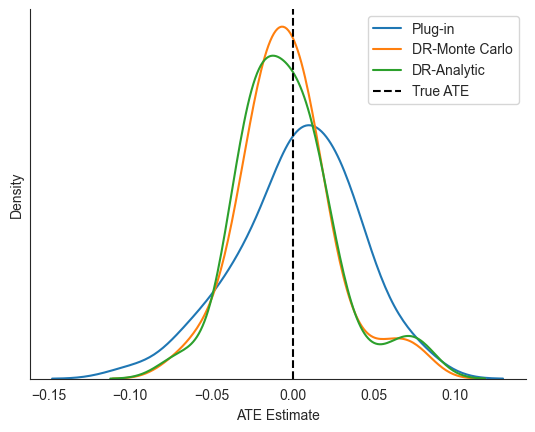

In [15]:
# Visualize the results
fig, ax = plt.subplots()

sns.kdeplot(
    results['plug_in_ate'], 
    label="Plug-in", ax=ax
)

sns.kdeplot(
    results['automated_monte_carlo_correction'], 
    label="DR-Monte Carlo", ax=ax
)

sns.kdeplot(
    results['analytic_correction'], 
    label="DR-Analytic", ax=ax
)

ax.axvline(0, color="black", label="True ATE", linestyle="--")
ax.set_yticks([])
sns.despine()
ax.legend(loc="upper right")
ax.set_xlabel("ATE Estimate")

plt.savefig("figures/doubly_robust_ate_estimates.pdf", dpi=300)

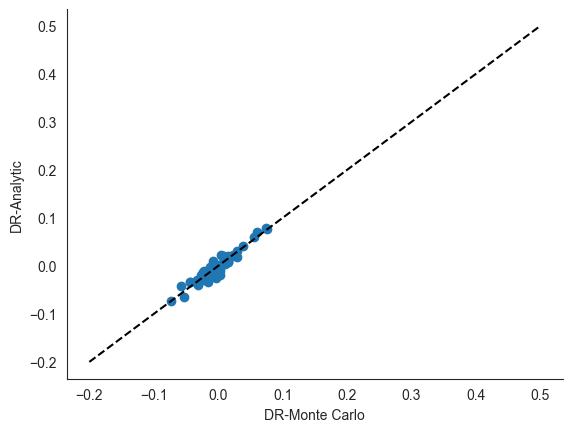

In [16]:
plt.scatter(
    results['automated_monte_carlo_correction'],
    results['analytic_correction'],
)
plt.plot(np.linspace(-.2, .5), np.linspace(-.2, .5), color="black", linestyle="dashed")
plt.xlabel("DR-Monte Carlo")
plt.ylabel("DR-Analytic")
sns.despine()
plt.savefig("figures/doubly_robust_ate_estimates_scatter.pdf", dpi=300)

## References

Kennedy, Edward. "Towards optimal doubly robust estimation of heterogeneous causal effects", 2022. https://arxiv.org/abs/2004.14497.